<!-- ---
title: GAN_evaluation_using_FID_and_IS
date: 2021-08-11
downloads: true
sidebar: true
tags:
  - GAN Evaluation
  - Inception Score
  - Frechet Inception Distance
--- -->
# **GAN Evaluation : the Frechet Inception Distance and Inception Score metrics**

In this notebook, two `PyTorch-Ignite`'s metrics to evaluate _Generative Adversarial Networks_ (or GAN in short) are introduced :
* **Frechet Inception Distance**, details can be found in [`Heusel et al. 2002`](https://arxiv.org/pdf/1706.08500.pdf)
* **Inception Score**, details can be found in [`Barratt et al. 2018`](https://arxiv.org/pdf/1801.01973.pdf)

See [here](https://github.com/pytorch/ignite/tree/master/ignite/metrics/gan) for more details about the implementation of the metrics in [PyTorch-Ignite](https://github.com/pytorch/ignite).

Most of the code here is from [DCGAN example](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) in [pytorch/examples](https://github.com/pytorch/examples). In addition to the original tutorial, this notebook will use in-built GAN based metric in `ignite.metrics` to evaluate Frechet Inception Distnace and Inception Score and showcase other metric based features in `ignite`.


About PyTorch-Ignite, please refer to [Github](https://github.com/pytorch/ignite) and [Documentation](https://pytorch.org/ignite/).<!--more-->

# Required Dependencies

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 8.1 MB/s 


In [ ]:
import torch
torch.__version__

'1.9.0+cu102'

In [ ]:
import torchvision
torchvision.__version__

'0.10.0+cu102'

In [ ]:
import ignite
ignite.__version__

'0.4.6'

# Import Libraries

In [ ]:
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

## Reproductibility and logging details


In [ ]:
ignite.utils.manual_seed(999)

The `logging` level `logging.WARNING` is used in internal `ignite` submodules in order to avoid internal messages.

In [ ]:
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<Logger ignite.distributed.launcher.Parallel (WARNING)>

# Processing Data

The [Large-scale CelebFaces Attributes (CelebA) Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is used in this tutorial. The `torchvision` library provides a [dataset class](https://pytorch.org/vision/stable/datasets.html#celeba), However this implementation suffers from issues related to the download limitations of `gdrive`. Here, we define a custom `CelebA` [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).


In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
!gdown --id 1O8LE-FpN79Diu6aCvppH5HwlcR5I--PX

Downloading...
From: https://drive.google.com/uc?id=1O8LE-FpN79Diu6aCvppH5HwlcR5I--PX
To: /content/img_align_celeba.zip
1.44GB [00:13, 107MB/s]


In [ ]:
!mkdir data
!unzip -qq img_align_celeba.zip -d data

## Dataset and transformation

The image size considered in this tutorial is `64`. Note that increase this size implies to modify the GAN models.

In [ ]:
image_size = 64

In [ ]:
data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
train_dataset = ImageFolder(root="./data", transform=data_transform)

In [ ]:
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))

## DataLoading

In [ ]:
batch_size = 128

We wish to configure the dataloader to work in a disbtributed environment. Distributed Dataloading is support by Ignite as part of DDP support. This requires specific adjustments to the sequential case.

To handle this, `idist` provides an helper [`auto_dataloader`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_dataloader.html#auto-dataloader) which automatically distributes the data over the processes.

**Note**: Distributed dataloading is described in [Distributed Data Parallel (DDP)](https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) tutorial if you wish to learn more.

In [ ]:
train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)

Let's explore the data.

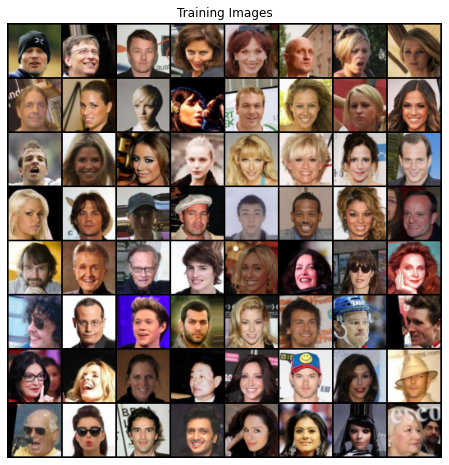

In [ ]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Models for GAN

## Generator

The latent space dimension of input vectors for the generator is a key parameter of GAN.

In [ ]:
latent_dim = 100

## Generator

In [ ]:
class Generator3x64x64(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3x64x64, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # final state size. 3 x 64 x 64
        )

    def forward(self, x):
        x = self.model(x)
        return x

As for dataloading, distributed models requires some specifics that `idist` adresses providing the [`auto_model`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_model.html#auto-model) helper.

In [ ]:
netG = idist.auto_model(Generator3x64x64(latent_dim))

Note that the model is automatically moved to the best device detected by `idist`.

In [ ]:
idist.device()

device(type='cuda')

In [ ]:
summary(netG, (latent_dim, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

## Discriminator

In [ ]:
class Discriminator3x64x64(nn.Module):
    def __init__(self):
        super(Discriminator3x64x64, self).__init__()
        self.model = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
netD = idist.auto_model(Discriminator3x64x64())

In [ ]:
summary(netD, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
Total params: 2,765,568
Trainable param

## Optimizers

The [Binary Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss) is used in this tutorial.

In [ ]:
criterion = nn.BCELoss()

A batch of `64` fixed samples will be used for generating images from throughout the training. This will allow a qualitative evaluation throughout the training progress.

In [ ]:
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())

Finally, two separate optimizers are set up, one for the generator, and one for the discriminator. Yet, another helper method [`auto_optim`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.auto.auto_optim.html#auto-optim) provided by `idist` will help to adapt optimizer for distributed configurations. 

In [ ]:
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

# Ignite Training Concepts

Training in Ignite is based on three core components, namely, Engine, Events and Handlers. Let's briefly discuss each of them.

*   **Engine** - The [Engine](https://pytorch.org/ignite/v0.4.5/generated/ignite.engine.engine.Engine.html#engine) can be considered somewhat similar to a training loop. It takes a `train_step` as an argument and runs it  over each batch of the dataset, emmiting events as it goes.

*   **Events** - [Events](https://pytorch.org/ignite/v0.4.5/generated/ignite.engine.events.Events.html#events) are emmited by the Engine when it reaches a specific point in the run/training.

*   **Handlers** - These are [functions](https://pytorch.org/ignite/v0.4.5/handlers.html#ignite-handlers) which can be configured so that they are triggered when a certain Event is emmited by the Engine. Ignite has a long list of pre defined Handlers such as checkpoint, early stopping, logging and built-in metrics.

## Training Step Function

A training step function will be run batch wise over the entire dataset by the engine. It contains the basic training steps, namely, running the model, propagating the loss backward and taking an optimizer step. We run the discriminator model on both real images and fake images generated by the Generator model. The function returns Generator and Discriminator Losses and the output generated by Generator and Discriminator.

In [ ]:
real_label = 1
fake_label = 0

In [ ]:
def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

A `PyTorch-Ignite` engine `trainer` is defined using the above `training_step` function.

In [ ]:
trainer = Engine(training_step)

### Handlers
In this section, the used `PyTorch-Ignite` handlers are introduced. These handlers will be responsible for printing out and storing important information such as losses and model predictions.

Like the DCGAN paper, we will also randomly initialize all the model weights from a Normal Distribution with `mean=0`, `stdev=0.02`. The following `initialize_fn` function must be applied to the generator and discriminator models at the start of training.

In [ ]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

The following `init_weights` handler is triggered at the start of the engine run and it is responsible for applying the `initialize_fn` function to randomly generate weights for the Generator `netD` and the Discriminator `netG`.

In [ ]:
@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

The `store_losses` handler is responsible for storing the generator and discriminator losses in `G_losses` and `D_losses` respectively. It is triggered at the end of every iteration.

In [ ]:
G_losses = []
D_losses = []

In [ ]:
@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])

The `store_images` handler is responsible for storing the images generated by the generator model during training. It provides us with a visual progress of the training. It is triggered every `500` iterations.

In [ ]:
img_list = []

In [ ]:
@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)

## Evaluation Metrics

For this tutorial, we will be showcasing two GAN based metric, namely, Frechet Inception Distance (FID) and Inception Score (IS). 

Inception Score (IS) is an objective metric for evaluating the quality of generated images, specifically synthetic images output by generative adversarial network models. It uses the classification probabilities provided by a pre-trained Inceptionv3 Model to measure performance of a GAN. You can find more Inception Score in the paper found [here](https://arxiv.org/pdf/1801.01973.pdf).

Frechet Inception Distance (FID) is a metric that calculates the distance between feature vectors calculated for real and generated images. Like IS, it also uses a pre-trained Inceptionv3 model. It uses the mean and covariance between the real and generated images' feature vectors to measure performance of a GAN. You can find more about Frechet Inception Distance in the paper found [here](https://arxiv.org/pdf/1706.08500.pdf)


These metric are provided by the [`ignite.metric`](https://pytorch.org/ignite/v0.4.5/metrics.html) submodule which provides a way to compute various quantities of interest in an online fashion without having to store the entire output history of a model. 

In this example, the `FID` and `IS` metrics are computed every epoch, therefore an specific handler `log_training_results` should be triggered every epoch. Since the metric run on the entire dataset a separate engine `train_evaluator` is defined which will be run by `log_training_results` handler. 

In [ ]:
from ignite.metrics import FID, InceptionScore

The `FID` and `InceptionScore` metrics are created as the following. Here we wish to use `gpu` so we set the device to `idist.device()` but the metrics will be on `cpu` device by default if no metric is passed.

In [ ]:
fid_metric = FID(device=idist.device())

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [ ]:
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])

The argument `output_transform` is run on the value returned by the engine. Since `InceptionScore` takes only single image as input whereas two values are returned by the engine, the function `output_transform` is used. As the name suggests, `output_transform` function is applied to the engine's output before it is provided to the metric for evaluation, so using `lambda x: x[0]` will ensure the InceptionScore metric only gets the first value for evaluation.

## Evaluators

We define the function for the evaluation engine, namely, `evaluation_step`. Our dataset provides `64 x 64 x 3` images but both `IS` and `FID` metrics use the `Inceptionv3` model for evaluation which requires images of minimum size `299 x 299 x 3`, so the images from the dataset and the images generated by the generator model must be interpolated.

Although pytorch has a native interpolate function, `PIL` interpolation is used instead because of poor anitaliasing in torch which can lead to poor scaling of images. These inconsistencies among implementations can have a drastic effect on the evaluations metrics and their final results. [Parmar et al. (2021)](https://arxiv.org/abs/2104.11222) explains in much greater detail about the differences and inconsistencies in the interpolation functions of various libraries.

In [ ]:
import PIL.Image as Image

In [ ]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)

In [ ]:
def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

The `train_evaluator` engine will run the metric on the entire dataset every epoch and attach `IS` and `FID` metrics to it.

In [ ]:
evaluator = Engine(evaluation_step)

In [ ]:
fid_metric.attach(evaluator, "fid")

In [ ]:
is_metric.attach(evaluator, "is")

The following handler attached to the `trainer` engine triggered every epoch will run the `train_evaluator` engine to evaluate the `IS` and `FID` metrics. The results are finally stored per epoch.

In [ ]:
fid_values = []
is_values = []

In [ ]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

## Loss metrics

The `RunningAverage` metric is used to keep track of the generator and discriminator Losses. Like the name suggests, `RunningAverage` keeps the track of average of all the values provided to it.

In [ ]:
from ignite.metrics import RunningAverage

In [ ]:
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

## Progress bars

Since the training process can take a lot of time and have a lot of iterations and epochs, a `ProgressBar` handler is added to show progress to prevent all the training data from filling up our screen.



In [ ]:
from ignite.contrib.handlers import ProgressBar

In [ ]:
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])

In [ ]:
ProgressBar().attach(evaluator)

## Training

Finally, the `trainer` engine is run here. The helper method [`Parallel`](https://pytorch.org/ignite/v0.4.5/generated/ignite.distributed.launcher.Parallel.html#parallel) of `idist` will help setting up a distributed configuration to run the `trainer` engine. It support  `nccl`, `gloo` and `mpi` native torch backends, `XLA` on `TPU` and `Horovod` distributed framework.

In [ ]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=5)

In [ ]:
with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch [1/5] Metric Scores
*   FID : 0.074513
*    IS : 2.016599


Epoch [2/5] Metric Scores
*   FID : 0.033024
*    IS : 2.243377


Epoch [3/5] Metric Scores
*   FID : 0.024583
*    IS : 2.346609


Epoch [4/5] Metric Scores
*   FID : 0.015189
*    IS : 2.514534


Epoch [5/5] Metric Scores
*   FID : 0.015975
*    IS : 2.544078


## Inference

Finally, let's check out the results. First, how the discriminator's and generator’s losses changed during training. Second, the `FID` and `IS` performance improvments of the model. And last, look a batch of real data next to a batch of fake data from the generator.

**Losses versus training iterations**

Below is a plot of the discriminator's and generator’s losses versus training iterations.

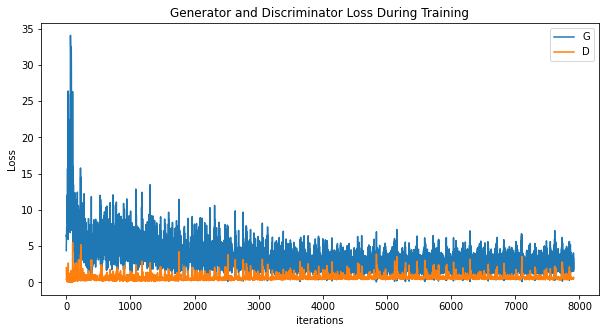

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

**Evaluation Metric versus training iterations**

Below is a plot of Evaluation versus training iterations.
As we can see `IS` increases sharply at first indicating the generator model is learning quickly how to generate faces. Unlike `IS`, `FID` is decreasing sharply at first similarly indicating the learning process of the generator model. 

Note: Higher value of `FID` implies better results and lower value of `IS` implies better results.

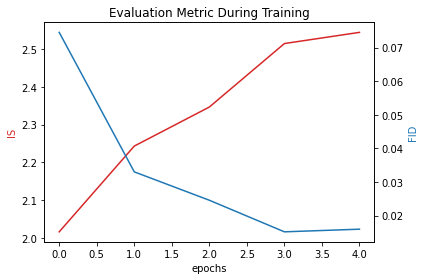

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by side.



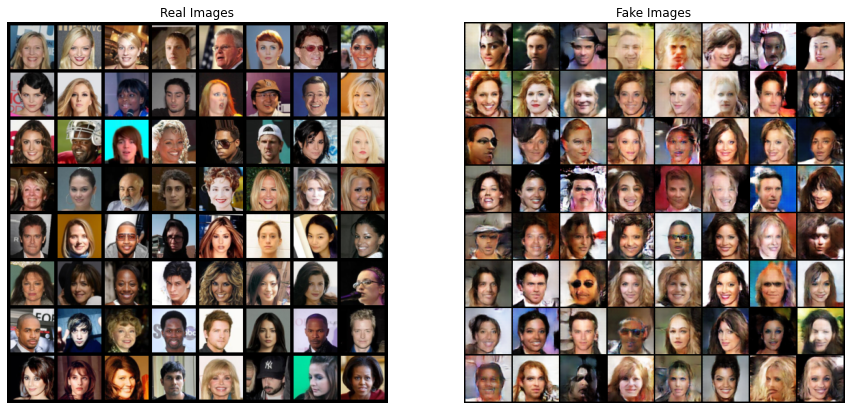

In [ ]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))